In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(100, 100, 3)
(224, 224, 3)
torch.Size([1, 3, 224, 224])


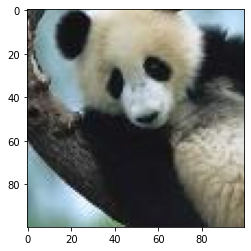

In [3]:
#图像加载以及预处理
orig = cv2.imread('cropped_panda.jpg')[..., ::-1]
print(orig.shape)

plt.imshow(orig)
orig = cv2.resize(orig, (224, 224))

print(orig.shape)
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = torch.from_numpy(img).to(device).float()
print(img.shape)

In [4]:
def handle(img,model,ori_label):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_pixels = 1000
    min_,max_ = -1,1

    now_img = img.to("cpu")
    h = img.shape[2]
    w = img.shape[3]
    pixels = np.random.permutation(h*w)
    pixels = pixels[:max_pixels]

    for pixel in pixels:
        x = pixel%w
        y = pixel//w
        location = [x,y]
        location = tuple(location)
        for value in [min_,max_]:
            now_img[0][0][x][y] = value
            now_img[0][1][x][y] = value
            now_img[0][2][x][y] = value
            now_img = now_img.to("cuda")
            # print(now_img[0][0][x][y],img[0][0][x][y])
            label=np.argmax(model(now_img).data.cpu().numpy())
            if label!=ori_label:
                print("nowlabel:{}".format(label))
                return now_img,label

In [5]:
#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()
label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))

label=388


In [6]:
now_img,now_label = handle(img,model,label)
print(now_label)

nowlabel:257
257


In [7]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    plt.figure()
    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

(3, 224, 224)


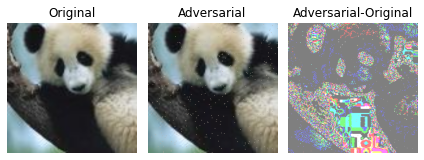

In [8]:
adv=now_img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
#adv = adv[..., ::-1]  # RGB to BGR
adv = np.clip(adv, 0, 255).astype(np.uint8)
show_images_diff(orig,label,adv,now_label)

In [9]:
sum = np.argwhere(orig==adv)
print(sum)

[[  0   0   0]
 [  0   0   1]
 [  0   0   2]
 ...
 [223 223   0]
 [223 223   1]
 [223 223   2]]


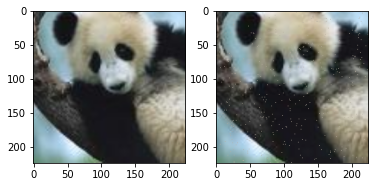

In [10]:
plt.subplot(1,2,1)
plt.imshow(orig)
plt.subplot(1,2,2)
plt.imshow(adv)